# multimodal-maestro + GPT-4 Vision

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Thu Nov 30 16:48:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os

HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Install `maestro`

In [ ]:
!pip install -q maestro==0.1.0rc1

In [ ]:
import maestro

print(maestro.__version__)

0.1.0rc1


## Download Data

**NONE:** Let's download few example images. Feel free to use your images.

In [ ]:
!mkdir -p {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data

## Imports

In [ ]:
import cv2
import numpy as np
import supervision as sv
import torch

import maestro

## Run `maestro`

**load image**

In [ ]:
image = cv2.imread("/content/data/dog.jpeg")

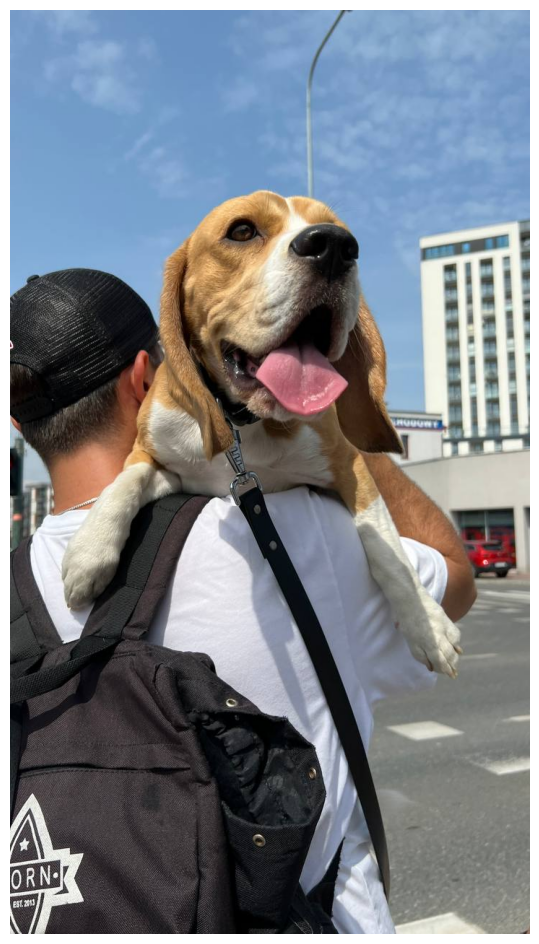

In [ ]:
sv.plot_image(image)

**create marks**

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
generator = maestro.SegmentAnythingMarkGenerator(device=device)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.56G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [ ]:
marks = generator.generate(image=image)

**visualize marks**

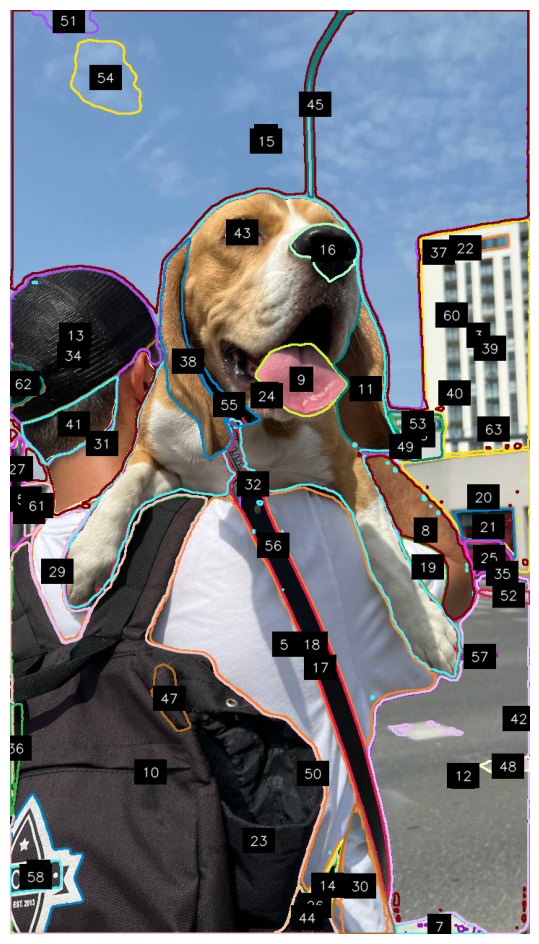

In [ ]:
mark_visualizer = maestro.MarkVisualizer()
marked_image = mark_visualizer.visualize(image=image, marks=marks)
sv.plot_image(marked_image)

**refine marks**

In [ ]:
refined_marks = maestro.refine_marks(marks=marks, minimum_mask_area=0.04)

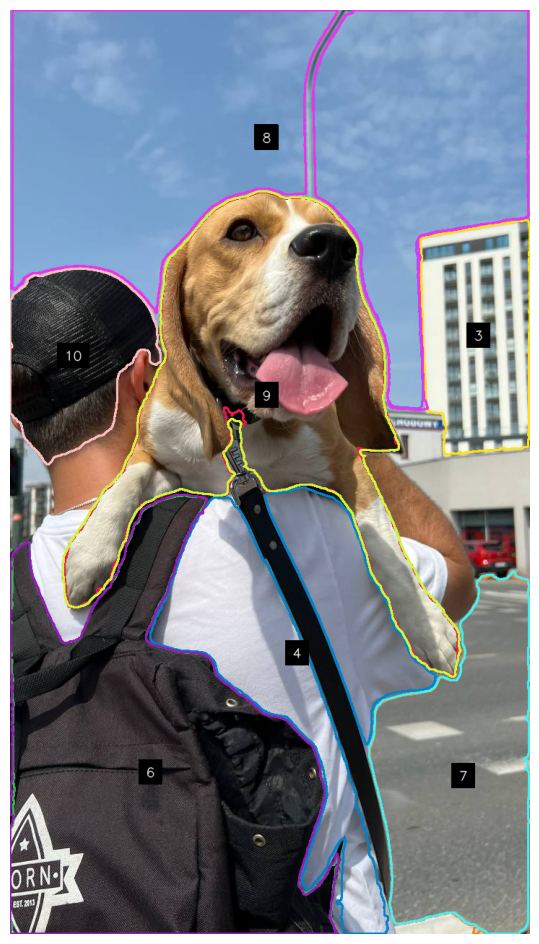

In [ ]:
mark_visualizer = maestro.MarkVisualizer()
marked_image = mark_visualizer.visualize(image=image, marks=refined_marks)
sv.plot_image(marked_image)

**prompt with marks**

In [ ]:
api_key = "..."

prompt = "Find backpack. notalk;justgo"

In [ ]:
response = maestro.prompt_image(api_key=api_key, image=marked_image, prompt=prompt)
response

'The backpack is marked by the number [6]. It is on the back of the person in the foreground.'

**extract and visualize relevant marks**

In [ ]:
masks = maestro.extract_relevant_masks(text=response, detections=refined_marks)
masks = np.array([mask for mask in masks.values()])
detections = maestro.masks_to_marks(masks)

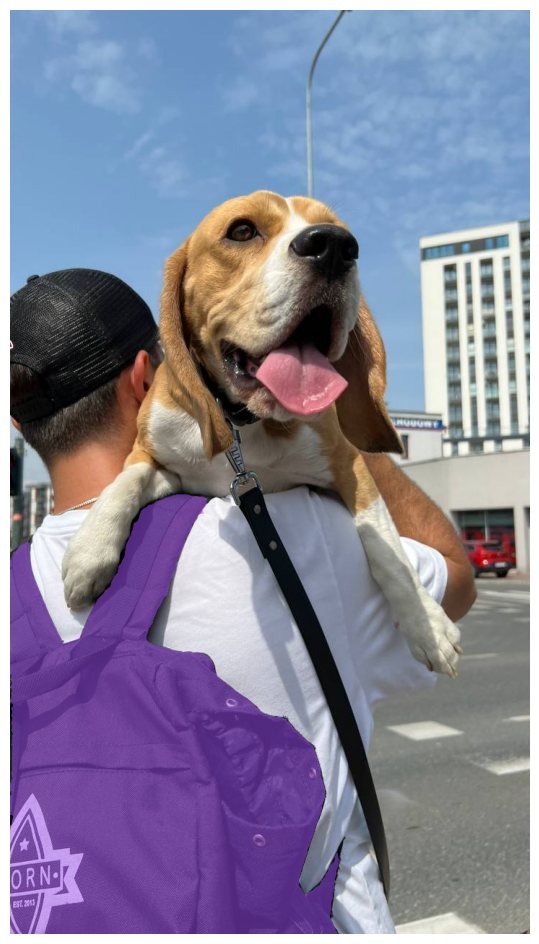

In [ ]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
annotated_frame = mask_annotator.annotate(scene=image.copy(), detections=detections)

sv.plot_image(annotated_frame)